In [1]:
import os
import argparse
import torch
import math
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


%load_ext autoreload
%autoreload 1

%aimport Models.ganConv, Models.SignDataLoad

In [32]:
#Parameters
parameters={
'n_epochs': 10, #number of epochs of training
'batch_size': 300, #size of the batches
"lrG":0.001, #adam: learning rate for generator
"lrD":0.0001, #adam: learning rate for discriminator
'b1': 0.5, #adam: decay of first order momentum of gradient
'b2':0.999, #adam: decay of first order momentum of gradient
'latent_dim': 100, #dimensionality of the latent space
'n_classes': 6, #number of classes for dataset
'img_size': 28, #size of each image dimension
'channels': 1, #number of image channels
'sample_interval': 1000, # 'interval between image sampling'
'g_steps': 1
}

In [332]:
# Load the model if to use pretrained

generator = torch.load('generator_conv_short.pth')
discriminator = torch.load('discriminator_conv_short.pth')


In [3]:
# Configure data loader for DataSigns.csv

dataset = Models.SignDataLoad.DataSigns()
dataloader = torch.utils.data.DataLoader(
    dataset = dataset, batch_size=parameters['batch_size'], shuffle=True)

In [ ]:
#function for weights initilization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
# Initialize generator and discriminator
generator = Models.ganConv.Generator(parameters)
discriminator = Models.ganConv.Discriminator(parameters)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

#For training process to keep the best model
best_gen_loss = 1


In [34]:
# Put all variables and functions for training on GPU

cuda = True if torch.cuda.is_available() else False

# Loss functions
adversarial_loss = torch.nn.BCELoss()


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=parameters['lrG'], betas=(parameters['b1'], parameters['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=parameters['lrD'], betas=(parameters['b1'], parameters['b2']))

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


In [327]:
# Training 

# for training and evaluation enerator needs to be set explicitely
generator.train()

for epoch in range(parameters['n_epochs']):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(torch.unsqueeze(imgs.type(FloatTensor),1))
        labels = Variable(labels.type(LongTensor))

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, parameters['latent_dim']))))
        gen_labels = Variable(LongTensor(np.random.randint(0, parameters['n_classes'], imgs.shape[0])))

        
#####################################
        #  Train Discriminator
#####################################
        
#         for train_d in range(parameters['d_steps']):
            
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss for fake images
        validity_fake = discriminator(torch.unsqueeze(gen_imgs.detach(),1), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

#####################################
        #  Train Generator
#####################################
#         for train_g in range(parameters['g_steps']):
        
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(torch.unsqueeze(gen_imgs,1), gen_labels)
        g_loss = adversarial_loss(validity, valid)

        #save the model with best loss:
        if (g_loss.item() < best_gen_loss) and (d_loss.item()<0.1):
            best_gen_loss = g_loss.item()
            generator_best = generator

        g_loss.backward()
        optimizer_G.step()
        
        
######################################
    # Track training
######################################
        
        batches_done = epoch * len(dataloader) + i
             

        if i==len(dataloader)-1:
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, parameters['n_epochs'], i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))
            generator.G_loss.append(g_loss.item())
            discriminator.D_loss.append(d_loss.item())

[Epoch 0/10] [Batch 28/29] [D loss: 0.146664] [G loss: 0.546934]
[Epoch 1/10] [Batch 28/29] [D loss: 0.108683] [G loss: 0.607878]
[Epoch 2/10] [Batch 28/29] [D loss: 0.100407] [G loss: 0.696033]
[Epoch 3/10] [Batch 28/29] [D loss: 0.113385] [G loss: 0.526998]
[Epoch 4/10] [Batch 28/29] [D loss: 0.143700] [G loss: 0.773362]
[Epoch 5/10] [Batch 28/29] [D loss: 0.102047] [G loss: 0.721267]
[Epoch 6/10] [Batch 28/29] [D loss: 0.082168] [G loss: 0.536611]
[Epoch 7/10] [Batch 28/29] [D loss: 0.097887] [G loss: 0.632714]
[Epoch 8/10] [Batch 28/29] [D loss: 0.111230] [G loss: 0.821364]
[Epoch 9/10] [Batch 28/29] [D loss: 0.130320] [G loss: 0.469843]


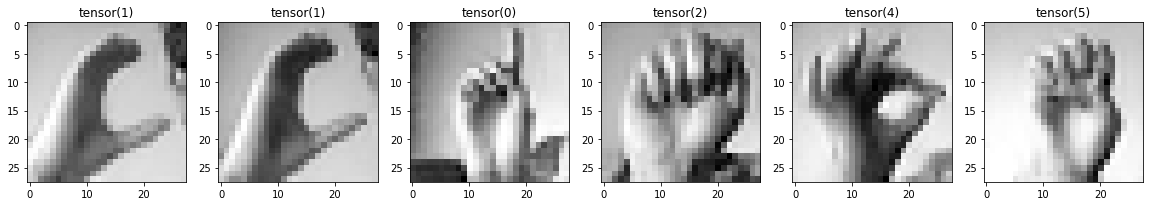

In [336]:
# Plot the evaluation of generator

# Sample noise and labels as generator input
z = Variable(FloatTensor(np.random.normal(0, 1, (6, parameters['latent_dim']))))
labels_check = Variable(LongTensor(np.random.randint(0, parameters['n_classes'], 6)))
# Generate images
generator.eval()
check_imgs = generator(z, labels_check)

fig = plt.figure(figsize=(20,20))
for show in range(6):
    ax = fig.add_subplot(1,6,show+1)
    ax.imshow(check_imgs.cpu().detach().numpy()[show,:,:], cmap='gray')
    plt.title(str(labels_check[show].cpu().detach()))

In [314]:
#Saving the model
torch.save(generator, 'generator_conv_short.pth')
torch.save(discriminator, 'discriminator_conv_short.pth')

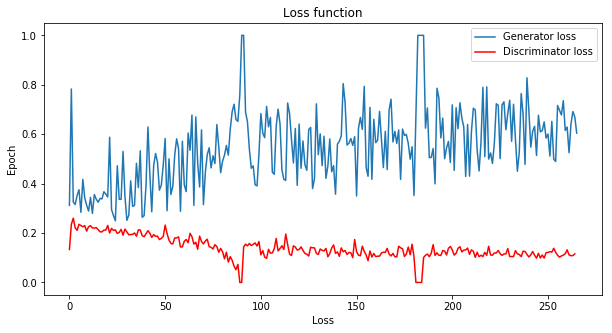

In [318]:
# Print loss function
plt.figure(figsize=(10,5))
plt.plot(generator.G_loss[1:], label='Generator loss')
plt.plot(discriminator.D_loss[1:], c='r', label = 'Discriminator loss')
plt.title('Loss function')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()

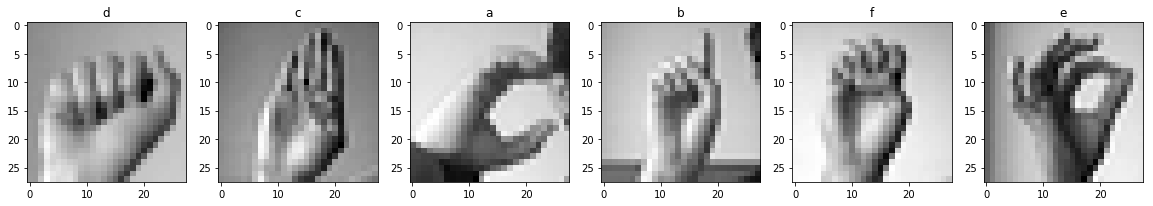

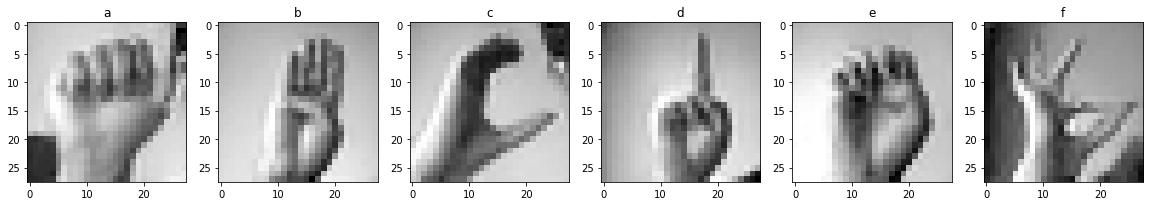

In [438]:
# Check KL divergence

import scipy 
from scipy.stats import entropy

signsVoc = {0:'d', 1: 'c', 2: 'a', 3: 'b', 4: 'f',
        5:'e'}


# Load real Data
data = np.loadtxt('/home/NISE/DataSigns.csv', delimiter=',', dtype=np.float32, skiprows=1)
labels = np.array(data[:, 0])
data_img = np.squeeze(data[np.where(labels<6), 1:])
labels = labels[np.where(labels<6)]

#Construst data for 6 classes
data_check = []
for cl in range(6):
    to_add = data_img[np.nonzero(labels==cl)[0][1], :]
    min_max = np.amax(to_add) - np.amin(to_add)
    im_row = to_add - np.amin(to_add)
    im_row = im_row/min_max
    data_check.append(im_row)
    
data_check = np.array(data_check)

#Plot the real data
fig1 = plt.figure(figsize=(20,20))
i=0
for img in data_check:
    img_reshape = img.reshape((28,28))
    ax = fig1.add_subplot(1,6,i+1)
    ax.imshow(img_reshape, cmap='gray')
    plt.title(signsVoc[i])
    i+=1
    
        
# Generate images
# Sample noise and labels as generator input
z = Variable(FloatTensor(np.random.normal(0, 1, (6, parameters['latent_dim']))))
labels_check = Variable(LongTensor(np.array([2, 3, 1, 0, 5, 4])))
# Generate images
generator.eval()
check_imgs = generator(z, labels_check).cpu().detach().numpy()

# Plot generated images
i=0
fig = plt.figure(figsize=(20,20))
for show in [2, 3, 1, 0, 5, 4]:
    ax = fig.add_subplot(1,6,i+1)
    ax.imshow(check_imgs[i,:,:], cmap='gray')
    plt.title(signsVoc[show])
    i+=1

check_imgs = check_imgs.reshape((check_imgs.shape[0],-1))
                           

(-0.5, 5.5, 5.5, -0.5)

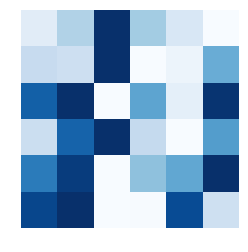

In [411]:
# Check KL divergence (2nd part)

# Normalize images
min_max = np.amax(check_imgs, axis=1) - np.amin(check_imgs, axis=1)
check_imgs = check_imgs - np.amin(check_imgs, axis=1).reshape(-1,1)
check_imgs = check_imgs/min_max.reshape(-1,1)


# function that for KL divergence
def similarity(gen_img, data_check):
    
    kl = []
    for img in data_check:
        kl.append(entropy(img+0.000001, gen_img+0.000001)) #to avoid div by zero
        
    return kl

# Check the KL divergence for real vs genrated images 
sim_full = []
for image_sim in data_fake:
    to_add = np.array(np.array(similarity(image_sim, data_check)))
    sim_full.append(to_add)

# Normalize for better visualization
min_max = np.amax(sim_full, axis=1) - np.amin(sim_full, axis=1)
sim_full = sim_full - np.amin(sim_full, axis=1).reshape(-1,1)
sim_full = sim_full/min_max.reshape(-1,1)

 
cells = np.array(sim_full)
img = plt.imshow(cells)
img.set_cmap('Blues')
plt.axis('off')